In [102]:
from icecube import dataclasses, phys_services
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import spatial

In [200]:
# Nice plots
import matplotlib
matplotlib.rc('xtick', labelsize=14)#, labelweight = 'bold')
matplotlib.rc('ytick', labelsize=14)
#matplotlib.rc('title', labelsize=14)
matplotlib.rc('axes', labelsize = 14)
matplotlib.rc('ytick.minor', size=10)
matplotlib.rc('xtick.major', size=10)
matplotlib.rc("axes", linewidth=1.0, grid=True, facecolor='white')#, labelweight = 'bold')
matplotlib.rc("figure", facecolor='white', titlesize=14)
matplotlib.rc("lines", markeredgewidth=2.0, linewidth = 2)
#matplotlib.rc('figure', autolayout = True)
matplotlib.rc("grid", color='#888888', linewidth = 0.3)

In [6]:
## Let's define the 3 positions of the SDOMs I want
## Icecube uses meters for distances
sdom_positions = [dataclasses.I3Position(0, 0, 20),
                  dataclasses.I3Position(0, 0, 0.),
                  dataclasses.I3Position(0, 0, -20)]

In [58]:
# Let's define an example muon using the icecube dataclasses
# Make an instance of the class
muon = dataclasses.I3Particle()
# Add an injection point and time
muon.pos = dataclasses.I3Position(1, 1, 100)
muon.time = 0.
# Set the direction
zenith = 0.
theta = np.pi - zenith 
muon.dir.set_theta_phi(theta, np.pi)
# Make it infinite
muon.shape = dataclasses.I3Particle.InfiniteTrack

In [68]:
# Now calculate the arrival times using the I3Calculator that takes (particle, position) as arguments
times = []
for one_dom in sdom_positions:
    times.append(phys_services.I3Calculator.cherenkov_time(muon, one_dom))
    print 'Arrival time', times[-1]
    if len(times)>1:
        delta_t = times[-1]-times[-2]
        print 'Delta t', delta_t
        

Arrival time 271.178592654
Arrival time 337.891411693
Delta t 66.7128190396
Arrival time 404.604230733
Delta t 66.7128190396


In [238]:
# Let's write this in a function now
def getDeltaT(muon, sdoms, dist_threshold = 30):
    delta_times = np.zeros(2)
    times = np.zeros(3)
    distances = np.zeros(3)

    for idom, one_dom in enumerate(sdoms):
        times[idom] = phys_services.I3Calculator.cherenkov_time(muon, one_dom)
        distances[idom] = phys_services.I3Calculator.cherenkov_distance(muon, one_dom)
        if idom > 0:
            delta_t = times[idom]-times[idom-1]
            delta_times[idom-1] = delta_t
    # Check if the distances are reasonable
    if np.max(distances) > dist_threshold:
        return np.array([np.nan, np.nan])
    else:
        return np.array(delta_times)

In [239]:
phys_services.I3Calculator.cherenkov_distance?

In [240]:
t = getDeltaT(muon, sdom_positions)
print t

[66.71281904 66.71281904]


In [241]:
# We will pick the cos(zenith) angle, and do the random sampling in 
# phi and position in the top cap (radius and angle)
def pickCylinderPoint(cos_zenith,
                      phi = 0.,
                     chalf_height = 50., # cylinder properties, in m
                     cradius = 80): # cylinder properties, in m

    # Axis of the rotated cylinder
    theta = np.arccos(cos_zenith)
    uvec = np.array([np.cos(phi)*np.sin(theta),
                     np.sin(phi)*np.sin(theta),
                     np.cos(theta)])
    
    # Random angle for the position on the cap
    cap_angle = np.random.rand()*2.*np.pi
    
    # Find the vector from the axis of the rotated cylinder to that point in the cap
    # They are perpendicular, so uvec dot capvec = 0, let's figure out the third component
    capvec = np.array([np.cos(cap_angle), np.sin(cap_angle), np.nan])
    # uvec[0]*capvec[0] + uvec[1]*capvec[1] + uvec[2]*capvec[2] = 0
    capvec[2] = -(uvec[0]*capvec[0] + uvec[1]*capvec[1])/uvec[2]
    
    # Now let's find the radial position of that vector  
    
    # This is the area trick, the area of a disc is pi*r**2
    # To make the area equally likely, I must pick a point
    # And iterpret it to be R**2
    cap_radius = np.sqrt(np.random.rand())*cradius
    
    # To get the position of injection, simply sum the two vectors with magnitudes
    pos = uvec*chalf_height + capvec*cap_radius
    return pos
    
    # Lauren: check the cap distribution if you use radius instead of sqrt(radius)
    #cap_radius = np.random.rand()*cradius
    
    # Cap x,y
    #x = cap_radius*np.cos(cap_angle)
    #y = cap_radius*np.sin(cap_angle)
    #z = chalf_height
    #return x,y

In [242]:
# Test the function
p = pickCylinderPoint(0.8)
print p

[-27.24343734  -2.78798711  82.93257801]


In [252]:
def sampleDeltaT(cos_zenith,
                 sdoms,
                 max_distance = 30.,
                 cheight = 50.,
                 cradius = 60.,
                 nsamples = 5000,
                use_random_points = False):
    
    deltat_array = np.zeros([nsamples,2])
    muon = dataclasses.I3Particle()
    
    # Only relative times matter, use zero here
    muon.time = 0.
    
    # Make it infinite
    muon.shape = dataclasses.I3Particle.InfiniteTrack
    
    # Loop over the number of samples requested
    for k in range(nsamples):
        
        # Pick a random phi
        phi = np.random.rand()*2*np.pi
        
        # Make the muon
        if use_random_points:
            # Do a silly selection of points in a box
            # Introduced in case my fancy cylinder wasn't working
            pos = np.random.rand(3)*80
        else:
            pos = pickCylinderPoint(cos_zenith,
                                   cheight, cradius)
        
        # Place it in the right position
        muon.pos = dataclasses.I3Position(pos[0], pos[1], pos[2])
        
        # Set the direction
        zenith = np.arccos(cos_zenith)
        theta = np.pi - zenith
        
        muon.dir.set_theta_phi(theta, phi)
        
        # Calculate time differences
        deltat_array[k,:] = getDeltaT(muon, sdoms, max_distance)
    return deltat_array

In [244]:
d = sampleDeltaT(0.9, sdom_positions, max_distance = 50., nsamples = 10000)
# Remove the bad distances (signals that are too far)
far_muons = np.isnan(d[:,0])
d = d[~far_muons,:]
print 'Muons that were close enough to sample', d.shape[0]

Muons that were close enough to sample 1141


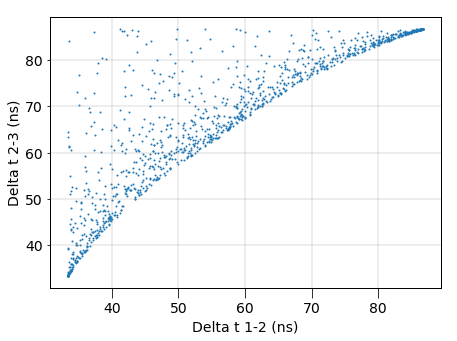

In [245]:
fig = plt.figure(figsize=(7,5))
plt.scatter(d[:,0], d[:,1],1, color='C0')
plt.xlabel('Delta t 1-2 (ns)')
plt.ylabel('Delta t 2-3 (ns)')

Cos(zenith) 1.0  - muons remaining 4246
Cos(zenith) 0.9999  - muons remaining 4219
Cos(zenith) 0.999  - muons remaining 4191
Cos(zenith) 0.99  - muons remaining 3970
Cos(zenith) 0.9  - muons remaining 3067


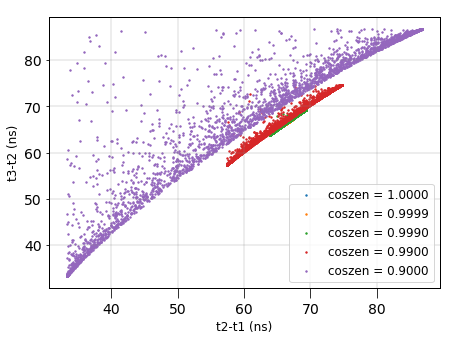

In [248]:
fig = plt.figure(figsize=(7,5))
# Now trying at 5 different cos(zenith) positions
coszen = np.array([1., 0.9999, 0.999, 0.99, 0.9])
#coszen = np.array([1., 0.999, 0.95, 0.9, 0.8, 0.6])
for i in range(len(coszen)):
    d = sampleDeltaT(coszen[i], sdom_positions, 
                     max_distance = 80., nsamples = 10000)
    # Remove the bad distances (signals that are too far)
    far_muons = np.isnan(d[:,0])
    d = d[~far_muons,:]
    
    print 'Cos(zenith)', coszen[i], ' - muons remaining', d.shape[0]
    plt.scatter(d[:,0], d[:,1],2, color='C'+"%i" % i,
               label = 'coszen = ' + "%0.4f" % coszen[i])
    
plt.xlabel('t2-t1 (ns)', fontsize='large')
plt.ylabel('t3-t2 (ns)', fontsize='large')
plt.legend(loc=0, fontsize='large')

Cos(zenith) 1.0  - muons remaining 4296
Cos(zenith) 0.95  - muons remaining 3714
Cos(zenith) 0.9  - muons remaining 3135
Cos(zenith) 0.8  - muons remaining 1933
Cos(zenith) 0.6  - muons remaining 911
Cos(zenith) 0.4  - muons remaining 733


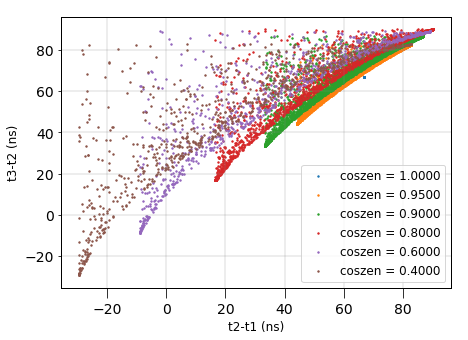

In [249]:
fig = plt.figure(figsize=(7,5))
# Now trying at 5 different cos(zenith) positions
#coszen = np.array([1., 0.9999, 0.999, 0.99, 0.9])
coszen = np.array([1., 0.95, 0.9, 0.8, 0.6, 0.4])
for i in range(len(coszen)):
    d = sampleDeltaT(coszen[i], sdom_positions, 
                     max_distance = 80., nsamples = 10000)
    # Remove the bad distances (signals that are too far)
    far_muons = np.isnan(d[:,0])
    d = d[~far_muons,:]
    
    print 'Cos(zenith)', coszen[i], ' - muons remaining', d.shape[0]
    plt.scatter(d[:,0], d[:,1],2, color='C'+"%i" % i,
               label = 'coszen = ' + "%0.4f" % coszen[i])
    
plt.xlabel('t2-t1 (ns)', fontsize='large')
plt.ylabel('t3-t2 (ns)', fontsize='large')
plt.legend(loc=0, fontsize='large')

Cos(zenith) 1.0  - muons remaining 3403
Cos(zenith) 0.95  - muons remaining 2969
Cos(zenith) 0.9  - muons remaining 2947
Cos(zenith) 0.8  - muons remaining 2850
Cos(zenith) 0.6  - muons remaining 2581
Cos(zenith) 0.4  - muons remaining 2245


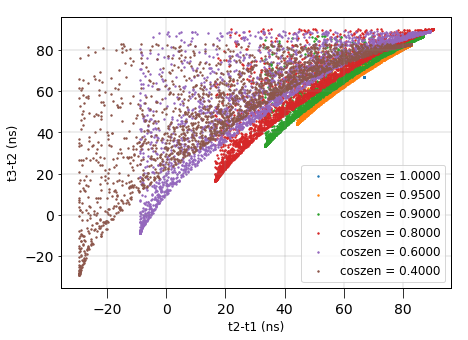

In [253]:
# Repeat figure above without the cylinder trick

fig = plt.figure(figsize=(7,5))
# Now trying at 5 different cos(zenith) positions
#coszen = np.array([1., 0.9999, 0.999, 0.99, 0.9])
coszen = np.array([1., 0.95, 0.9, 0.8, 0.6, 0.4])
for i in range(len(coszen)):
    d = sampleDeltaT(coszen[i], sdom_positions, 
                     max_distance = 80., nsamples = 10000,
                    use_random_points = True)
    # Remove the bad distances (signals that are too far)
    far_muons = np.isnan(d[:,0])
    d = d[~far_muons,:]
    
    print 'Cos(zenith)', coszen[i], ' - muons remaining', d.shape[0]
    plt.scatter(d[:,0], d[:,1],2, color='C'+"%i" % i,
               label = 'coszen = ' + "%0.4f" % coszen[i])
    
plt.xlabel('t2-t1 (ns)', fontsize='large')
plt.ylabel('t3-t2 (ns)', fontsize='large')
plt.legend(loc=0, fontsize='large')